## Binning quantities along isopycnals

This notebook demonstrates how to bin the ocean into density surfaces, using xgcm conservative binning, described at: https://xgcm.readthedocs.io/en/latest/transform.html

The computation is robust to different selections of density bins, but currently has issues with partial cells.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
#from gsw import SA_from_SP, p_from_z, sigma1
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Set up some parameters and open cluster.

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43915 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
year = '2170'
month = '01'
expt = '01deg_jra55v13_ryf9091'

time_slice= year + '-' + month
start_time = year + '-01-01'
end_time= year + '-12-31'

lat_range = slice(-70,-34.99)

In [5]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 1.71 s, sys: 370 ms, total: 2.08 s
Wall time: 15.3 s


### Load density and dzt (quantity being binned - you can choose any other quantity instead of dzt, but if it is not on t-grid then interpolate it to t-grid)

In [6]:
%%time

pot_rho_1 = cc.querying.getvar(expt,'pot_rho_1',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
pot_rho_1 = pot_rho_1.sel(yt_ocean=lat_range).sel(time=time_slice)
time = pot_rho_1.time
dzt = cc.querying.getvar(expt,'dzt',session,start_time=start_time, end_time=end_time,ncfile='%daily%')
dzt = dzt.sel(yt_ocean=lat_range).sel(time=time_slice)

CPU times: user 3.06 s, sys: 284 ms, total: 3.35 s
Wall time: 8.89 s


### Load vertical grid bin centres and edges

In [7]:
%%time

st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)
st_edges_ocean = cc.querying.getvar(expt,'st_edges_ocean',session,n=1)

CPU times: user 928 ms, sys: 91.6 ms, total: 1.02 s
Wall time: 1.26 s


### For simplicity, choose one time and longitude

Plot for one lat/lon and time (just a vertical column)

In [8]:
dzt = dzt.isel(time = 4, xt_ocean = 10)
pot_rho_1 = pot_rho_1.isel(time = 4, xt_ocean = 10)

Text(0.5, 1.0, '')

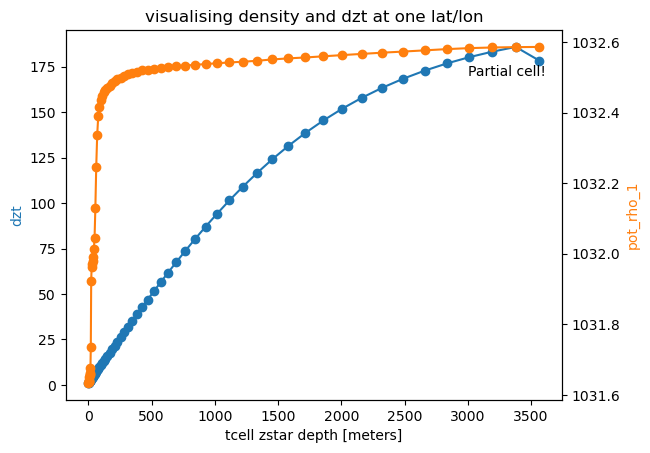

In [9]:
fig = plt.figure()
ax = plt.subplot()
dzt.isel(yt_ocean = 130).plot(ax = ax, marker = 'o')
ax2 = ax.twinx()
ax2.spines.right.set_position(("axes", 1))
pot_rho_1.isel(yt_ocean = 130).plot(ax = ax2, color = 'C1', marker = 'o')
ax.set_ylabel('dzt',color = 'C0')
ax2.set_ylabel('pot_rho_1', color = 'C1')
ax.text(3000,170,'Partial cell!')
ax.set_title('visualising density and dzt at one lat/lon')
ax2.set_title('')

### define *EDGE* of target density bins

Output will be an array with coordinate density the linear centre of these bins

In [10]:
pot_rho_1_target = np.array([1000, 1027.5  , 1028.5  , 1029.5  , 1030.5,1030.9  , 1031.2,1031.5 , 1031.7  ,
       1031.95 , 1032.05 , 1032.15 , 1032.225, 1032.275, 1032.325,1032.36,
       1032.39, 1032.41 , 1032.43 , 1032.45 , 1032.47 , 1032.49 ,
       1032.505, 1032.515, 1032.525, 1032.535, 1032.545, 1032.555,
       1032.57 , 1032.59 , 1032.7  , 1032.9  , 1033.5  , 1039.5  ,
       1045.5])


### and get rid of NaNs

In [11]:
dzt = dzt.fillna(0)
pot_rho_1 = pot_rho_1.fillna(0)

### calculate vertical regridding into density coordinates

According to xgcm tutorial:

In [12]:
%%time

ds = xr.Dataset({'dzt':dzt,'pot_rho_1':pot_rho_1}) #Note if not using dzt, quantity must be extensive e.g.vhrho_nt. If not extensive, multiply by dzt or dzu.#
ds = ds.assign_coords({'st_edges_ocean':st_edges_ocean})
ds = ds.chunk({'st_edges_ocean':76,'st_ocean':75}) #xgcm doesn't like it if there is more than 1 chunk in this axis
grid = xgcm.Grid(ds, coords={'Z':{'center':'st_ocean','outer':'st_edges_ocean'}},periodic = False)
ds['pot_rho_1_outer'] = grid.interp(ds.pot_rho_1, 'Z', boundary='extend')
ds['pot_rho_1_outer'] = ds['pot_rho_1_outer'].chunk({'st_edges_ocean':76})

dzt_transformed_cons = grid.transform(ds.dzt,
                                  'Z',
                                  pot_rho_1_target,
                                  method='conservative',
                                  target_data=ds.pot_rho_1_outer)
### change name to fit previous bins because xarray naming is weird. p
#pot_rho_1_outer is actually the CENTRE of bins (I guess the convention was defined for linear interpolation not conservative)
dzt_transformed_cons = dzt_transformed_cons.rename({'pot_rho_1_outer':'isopycnal_bins'})



CPU times: user 30.1 ms, sys: 11.5 ms, total: 41.6 ms
Wall time: 37.4 ms


Text(0.5, 1.0, 'comparing xgcm binned dzt to original')

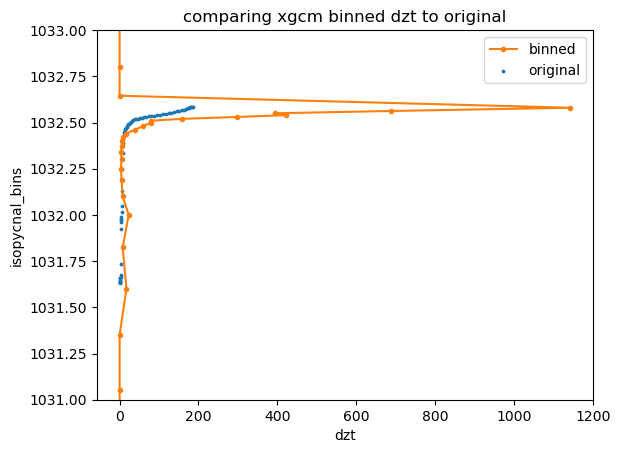

In [13]:
ds.isel(yt_ocean = 130).plot.scatter(y = 'pot_rho_1', x = 'dzt', s = 3, label = 'original')
dzt_transformed_cons.isel(yt_ocean = 130).plot(y = 'isopycnal_bins', marker = 'o', color = 'C1',markersize = 3, label = 'binned')
plt.ylim(1031,1033)
plt.legend()
plt.title('comparing xgcm binned dzt to original')

The bins I have chosen are thicker than actual intervals of density in this region of ocean

#### now account for partial cell at bottom: find what is missing from vertical integral (residual)

In [14]:
%%time
#find residual from vertical integral
dzt_residual = dzt.sum('st_ocean')-dzt_transformed_cons.sum('isopycnal_bins') #this is positive definite

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 19.1 ms


#### find bottom density of dzu_transformed_cons

In [15]:
%%time
# select out bottom values:
dzt_transformed_cons2 = dzt_transformed_cons.where(dzt_transformed_cons!=0) 
dens_array = dzt_transformed_cons2 * 0 + dzt_transformed_cons2.isopycnal_bins # array of isopycnal value where it exists and nan elsewhere
max_dens = dens_array.max(dim = 'isopycnal_bins', skipna= True)

CPU times: user 29.7 ms, sys: 967 µs, total: 30.7 ms
Wall time: 28.1 ms


#### add residual to this bottom density in array

In [16]:
%%time
dzt_residual_array = (dens_array.where(dens_array == max_dens)*0+1)*dzt_residual
h_new = dzt_residual_array.fillna(0)+ dzt_transformed_cons

CPU times: user 33.3 ms, sys: 4.53 ms, total: 37.9 ms
Wall time: 34.3 ms


Text(200, 1032.25, 'Note last nonzero cell has increased from previous plot')

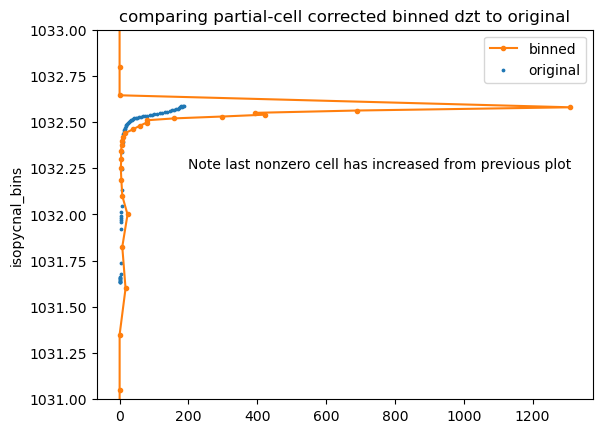

In [17]:
ds.isel(yt_ocean = 130).plot.scatter(y = 'pot_rho_1', x = 'dzt', s = 3, label = 'original')
h_new.isel(yt_ocean = 130).plot(y = 'isopycnal_bins', marker = 'o', color = 'C1',markersize = 3, label = 'binned')
plt.ylim(1031,1033)
plt.legend()
plt.title('comparing partial-cell corrected binned dzt to original')
plt.text(200,1032.25,'Note last nonzero cell has increased from previous plot')

#### Check: Load ht and eta_t from cosima cookbook

In [18]:
ht= cc.querying.getvar(expt,'ht',session,n=1)
ht = ht.sel(yt_ocean = lat_range)
eta_t = cc.querying.getvar(expt,'eta_t',session,ncfile='%daily%',start_time=start_time, end_time=end_time)
eta_t = eta_t.sel(yt_ocean=lat_range, time=time_slice)

Text(0.5, 1.0, 'comparing the ocean depth at one longitude')

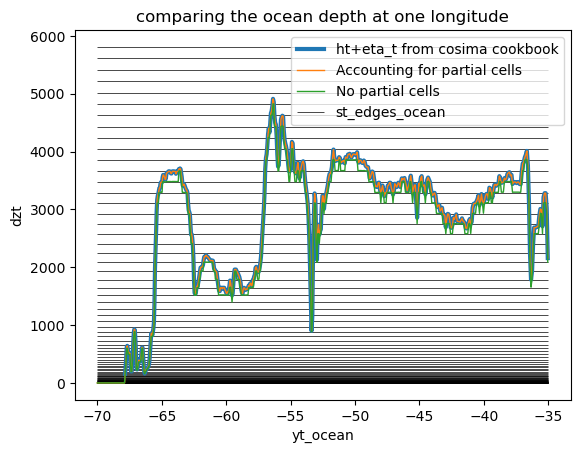

In [20]:
(ht.isel(xt_ocean=10)+eta_t.isel(xt_ocean=10,time = 4)).plot(linewidth = 3, label = 'ht+eta_t from cosima cookbook')
h_new.sum('isopycnal_bins').plot(label = 'Accounting for partial cells', linewidth = 1)
dzt_transformed_cons.sum('isopycnal_bins').plot(label = 'No partial cells', linewidth=1) 
plt.hlines(st_edges_ocean.values, -70,-35, color = 'k', linewidth=0.5, label = 'st_edges_ocean')
plt.legend()
plt.title('comparing the ocean depth at one longitude')

Indeed, the vertical sum of the binned (accounting for partial cells, orange) and original ocean depth (blue) are the same. When partial cells not accounted for (green line, the bottom of the ocean is jumpy and only follows the last st_edges_ocean).


This can be repeated for a quantity other than dzt, ensuring the quantity is extensive e.g. vhrho_nt, uhrho_et (or multiply by dzt if not already, e.g. v) and on the t-grid. 

The first part of the binning is very quick, but accounting for the partial cell scales badly if you want to do for a large range or include daily times.